In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee

In [2]:
df = pd.read_csv('gw.csv')
mo = df[['opponent_team', 'total_points']]
mo.head()

,opponent_team,total_points
0,10,14
1,4,10
2,14,17
3,16,2
4,3,6


In [3]:
teams_df = pd.read_csv('teams.csv')
teams_df.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,2,ARS,...,NaN,False,0,1350,1350,1390,1400,1310,1300,1
1,7,0,NaN,2,0,Aston Villa,0,0,6,AVL,...,NaN,False,0,1145,1240,1130,1180,1160,1300,2
2,91,0,NaN,3,0,Bournemouth,0,0,10,BOU,...,NaN,False,0,1170,1200,1120,1180,1220,1220,127
3,94,0,NaN,4,0,Brentford,0,0,8,BRE,...,NaN,False,0,1130,1180,1100,1100,1160,1260,130
4,36,0,NaN,5,0,Brighton,0,0,9,BHA,...,NaN,False,0,1140,1165,1090,1140,1190,1190,131


In [4]:
mo['fixture'] = mo['opponent_team'].map(teams_df.set_index('id')['strength_defence_home'])

/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/102581732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mo['fixture'] = mo['opponent_team'].map(teams_df.set_index('id')['strength_defence_home'])


In [5]:
form = []
for i in range(0, len(mo)):
    if i==0:
        form.append(0)
    elif i == 1:
        form.append(mo['total_points'].iloc[i])
    elif i == 2:
        form.append(np.mean(mo['total_points'].iloc[:i]))
    elif i == 3:
        form.append(np.mean(mo['total_points'].iloc[:i]))
    else:
        form.append(np.mean(mo['total_points'].iloc[i-4:i]))

In [6]:
mo['form'] = form

/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/994197318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mo['form'] = form


In [7]:
from scipy.stats import poisson
def get_model_predictions(theta, form, fixture):
    alpha, beta_1, beta_2, sigma = theta
    lam = alpha + beta_1*form + beta_2*fixture
    # Ensure sigma is positive to avoid domain errors
    draw = poisson.rvs(loc=lam) 
    return draw

In [8]:
def lnprior(theta):
    '''
    Calculate the log prior for the hierarchical model
    
    Parameters
    --------
    params : alpha, beta_1, beta_2, and sigma


    
    Returns
    --------
    lnp : float
        the log-prior for this set of parameters
    '''
    
    alpha, beta_1, beta_2, sigma = theta
    if -100<=alpha<=100 and -100<=beta_1<=100 and -100<=beta_2<=100 and 0 <= sigma <= 100:
        lnp = np.log(1/200) + np.log(1/200) + np.log(1/200) + np.log(1/100)
    else:
        lnp = -np.inf

    return lnp



In [9]:
def lnlikelihood(theta, observed_points, form, fixture, y_unc):
    y = observed_points
    model_preds = get_model_predictions(theta,form,fixture)
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl

In [10]:
def lnprob(theta, observed_points, form, fixture, y_unc):
    return lnprior(theta) + lnlikelihood(theta, observed_points, form, fixture, y_unc)

In [11]:
ndim, nwalkers = 4, 100
alpha0 = np.random.rand(nwalkers, 1)
beta_1_0 = np.random.rand(nwalkers, 1)
beta_2_0 = np.random.rand(nwalkers, 1)
sigma0 = np.random.rand(nwalkers, 1) * mo['total_points'].std()
p0 = np.hstack([alpha0, beta_1_0, beta_2_0, sigma0])

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mo['total_points'], mo['form'], mo['fixture'], mo['total_points'].std()))
sampler.run_mcmc(p0, 5000, progress=True)

emcee: Exception while calling your likelihood function:
  params: [0.07921214 0.57479014 0.43646794 4.60547636]
  args: (0     14
1     10
2     17
3      2
4      6
5     10
6      3
7     12
8     10
9      9
10    14
11    13
12    13
13    18
14     5
15    21
16     9
17    16
18     7
19     2
20     3
21     8
22    16
23    13
24     8
25    12
26    14
27     6
28    15
29     3
30     2
31     6
32     3
33     8
34     2
35     2
Name: total_points, dtype: int64, 0      0.000000
1     10.000000
2     12.000000
3     13.666667
4     10.750000
5      8.750000
6      8.750000
7      5.250000
8      7.750000
9      8.750000
10     8.500000
11    11.250000
12    11.500000
13    12.250000
14    14.500000
15    12.250000
16    14.250000
17    13.250000
18    12.750000
19    13.250000
20     8.500000
21     7.000000
22     5.000000
23     7.250000
24    10.000000
25    11.250000
26    12.250000
27    11.750000
28    10.000000
29    11.750000
30     9.500000
31     6.500000
32     6

Traceback (most recent call last):
  File "/opt/anaconda3/envs/day5/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/1081555364.py", line 2, in lnprob
    return lnprior(theta) + lnlikelihood(theta, observed_points, form, fixture, y_unc)
  File "/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/2378944248.py", line 3, in lnlikelihood
    model_preds = get_model_predictions(theta,form,fixture)
  File "/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/806864925.py", line 6, in get_model_predictions
    draw = poisson.rvs(loc=lam)
  File "/opt/anaconda3/envs/day5/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py", line 3117, in rvs
    return super().rvs(*args, **kwargs)
  File "/opt/anaconda3/envs/day5/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py", line 1064, in rvs
    args, loc, sca

TypeError: _parse_args_rvs() missing 1 required positional argument: 'mu'

In [ ]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print("Gelman-Rubin diagnostic (R-hat values):")
for i, label in enumerate(labels):
    chains = sampler.get_chain(discard=100)[:, :, i]
    n_chains = chains.shape[1]
    n_samples = chains.shape[0]
    
    # Calculate between-chain variance
    chain_means = np.mean(chains, axis=0)
    overall_mean = np.mean(chain_means)
    B = n_samples * np.var(chain_means, ddof=1)
    
    # Calculate within-chain variance
    chain_vars = np.var(chains, axis=0, ddof=1)
    W = np.mean(chain_vars)
    
    # Calculate R-hat
    var_plus = ((n_samples - 1) / n_samples) * W + (1 / n_samples) * B
    r_hat = np.sqrt(var_plus / W)
    
    print(f"{label}: {r_hat:.4f}")

Gelman-Rubin diagnostic (R-hat values):
alpha: 1.0613
beta1: 1.0633
beta2: 1.0532
sigma: 1.0954


In [ ]:
def plot_chains(ax, samples, i, labels):
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


Text(0.5, 0, 'step number')

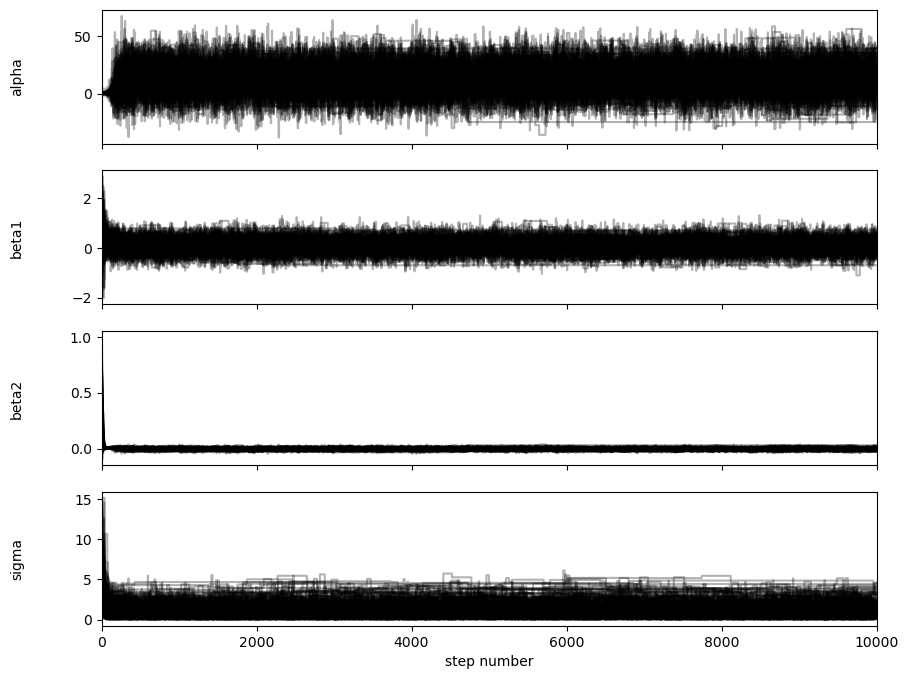

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "beta1", "beta2", "sigma"]
for i in range(ndim):
    plot_chains(axes[i], samples, i, labels)

axes[-1].set_xlabel("step number")

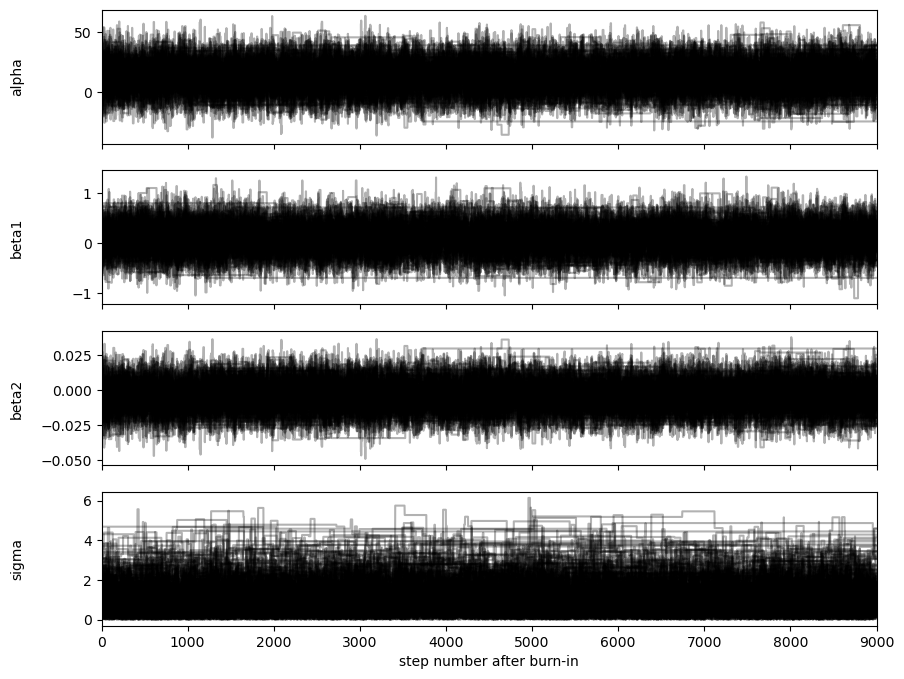

In [ ]:
flat_samples = sampler.get_chain(discard=1000)

fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
labels = ["alpha", "beta1", "beta2", "sigma"]
for i in range(ndim):
    plot_chains(axes[i], flat_samples, i, labels)

axes[-1].set_xlabel("step number after burn-in");

/opt/anaconda3/envs/day5/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (9000) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


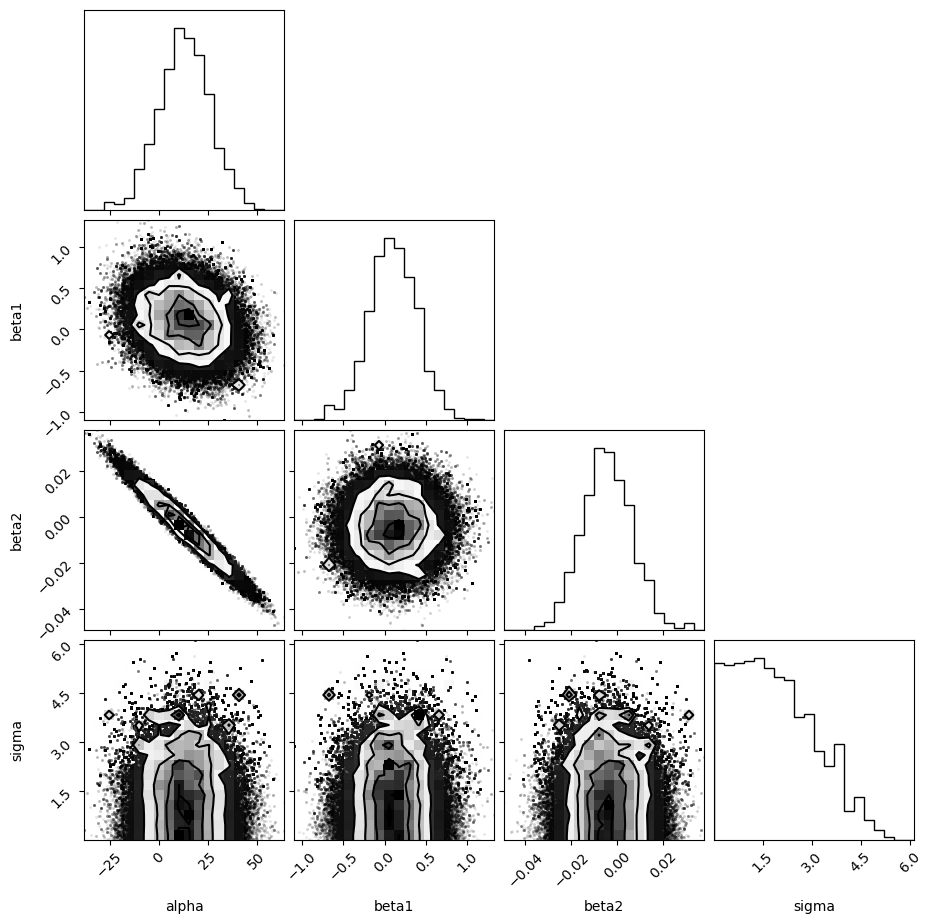

In [ ]:
import corner

fig = corner.corner(flat_samples, labels=labels)

In [ ]:
alpha = np.median(flat_samples[:,:, 0])
beta1 = np.median(flat_samples[:,:, 1])
beta2 = np.median(flat_samples[:,:, 2])
sigma = np.median(flat_samples[:,:, 3])

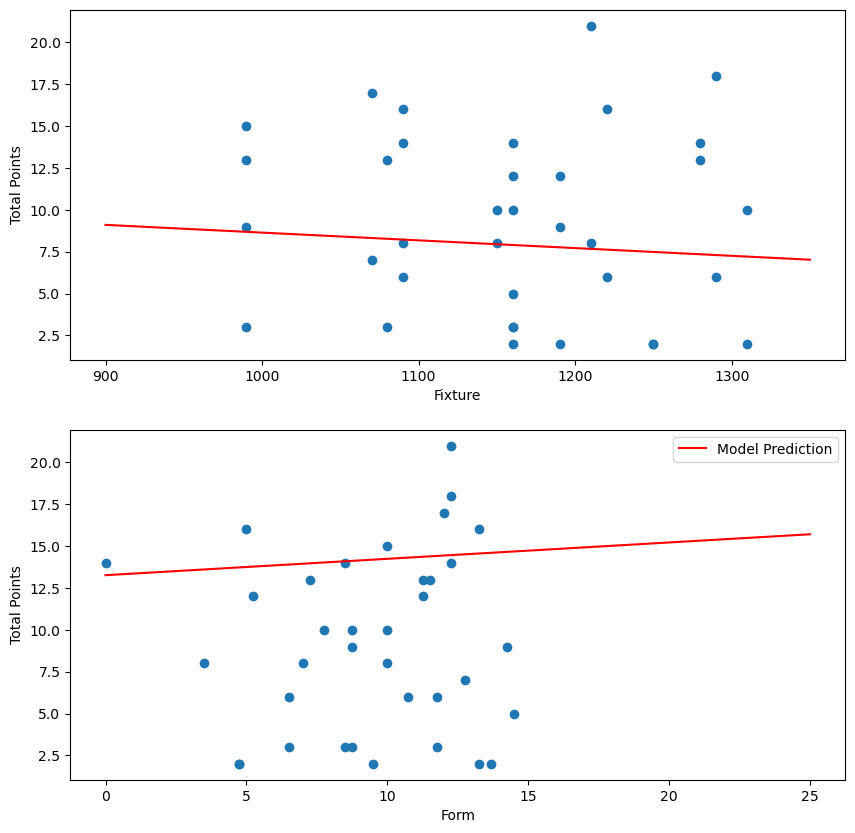

In [ ]:
fix, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 10))

ax=ax1
ax.scatter(mo['fixture'], mo['total_points'])
x_arr = np.linspace(900, 1350, 1000)
x_arr2 = np.linspace(0, 25, 1000)
ax.plot(x_arr, alpha + beta2 * x_arr, color='red', label='Model Prediction')
ax.set_xlabel('Fixture')
ax.set_ylabel('Total Points')

ax=ax2
ax.scatter(mo['form'], mo['total_points'])

ax.plot(x_arr2, alpha +beta1 * x_arr2, color='red', label='Model Prediction')
ax.set_xlabel('Form')
ax.set_ylabel('Total Points')
ax.legend()

(array([0.        , 0.        , 0.14285714, 0.11428571, 0.        ,
        0.02857143, 0.08571429, 0.02857143, 0.08571429, 0.05714286,
        0.08571429, 0.        , 0.05714286, 0.08571429, 0.08571429,
        0.02857143, 0.05714286, 0.02857143, 0.02857143, 0.        ]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

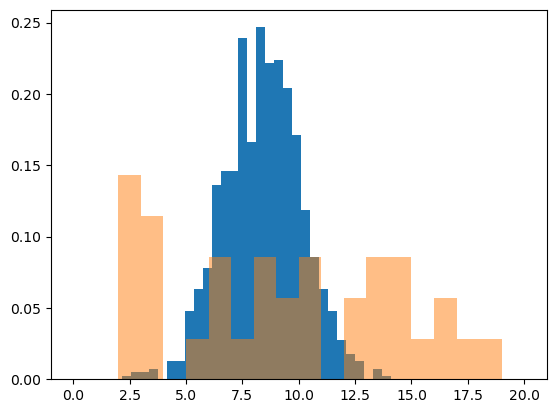

In [ ]:
points_next = norm.rvs(loc=alpha + beta2 * 1150 + beta1 * mo['form'].iloc[-1], scale=sigma, size=1000)
plt.hist(points_next, bins=30, density=True)
plt.hist(mo['total_points'], density=True, alpha=0.5, bins=np.arange(0, 21))

In [ ]:
#Poission likelihood